#Import

In [ ]:
import os
import time
import numpy as np
import pandas as pd
from typing import Tuple
import random
from collections import defaultdict
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# load env

.py 파일을 사용하기 위해서는 cwd (current working directory)를 파일이 있는 위치로 변경해야 한다.

In [ ]:
os.chdir('/content/drive/MyDrive') # os.chdir() : change directory / "내가 이 모듈을 실행하고 있는 동안은 모듈이 위치한 경로가 아니라 다른 경로에서 작업들을 수행하겠다"

In [ ]:
! python GridWorldEnvironment.py # 문장 맨 앞에 붙는 느낌표(!)는 파이썬에서가 아닌 os shell에서 코드를 실행시키기 위함이다.

In [ ]:
from GridWorldEnvironment import GridWorldEnvironment

#Dynamic Programming

## 01 Policy Iteration

`np.full(shape, fill_value, dtype=None, order='C')`

shape : 배열의 모양을 정수 또는 정수들로 이루어진 튜플로 지정한다

fill_value : 배열의 값을 지정

dtype : 배열의 자료형 지정

order : 'C' - 배열의 마지막 차원을 가장 먼저 변경 / 'F' - 첫 번째 차원을 가장 먼저 변경

`np.where(배열 이름 & 조건)`

조건을 만족하는 요소의 인덱스를 반환함

2차원 이상이면 axis(열)를 기준으로 차례대로 가져온다.

`np.where(a < 10, a * 2, a)`

-> a가 10보다 작으면 2배를 곱한 값을 반환, 그렇지 않으면 a의 해당 위치 값을 반환



In [ ]:
class PolicyIteration:
    def __init__(self,env):
        # 환경에 대한 객체 선언
        self.env = env
        self.action_space = env.action_space # ['up', 'down', 'left', 'right']
        self.num_action = len(self.action_space)

        # value 2d list
        self.value_table = np.zeros(shape=(env.height, env.width)).tolist()

        # 상하좌우 동일한 확률로 초기화
        self.policy_table = np.full(shape=(env.height, env.width, self.num_action), fill_value=0.25).tolist()

        # end state's policy table should be empty
        self.policy_table[env.end_point[0]][env.end_point[1]] = [] # end_point의 dtype은 tuple ~> 인덱싱 가능

        self.gamma = 0.9 # 할인율 discount factor


    def policy_evaluation(self):
        # value function update
        for state in self.env.total_states: # 모든 state에 대한 가치함수 값 구하기
            # 벨만 기대 방정식을 이용해 현재 정책에 대한 각 state의 가치를 구하기
            value = 0.0

            if state == self.env.end_point:
                self.value_table[state[0]][state[1]] = 0.0 # 목표 지점에 도착했을 때는 앞으로 받을 수 있는 보상이 더 이상 없으므로

            else:
                state_policy = self.get_policy(state)

                for action_idx in range(self.num_action): # 현재 state에서 할 수 있는 모든 행동에 대한
                    next_state = self.env.state_after_action(state, action_idx)
                    reward = self.env.get_reward(state, action_idx)
                    next_value = self.get_value(next_state)
                    value += state_policy[action_idx] * (reward + self.gamma * next_value)

                self.value_table[state[0]][state[1]] = value


    def policy_improvement(self):
        next_policy = self.policy_table

        for state in self.env.total_states:

            value_list = []

            #반환할 정책 초기화
            result = np.zeros(shape=(self.num_action)).tolist()

            for action_idx in range(self.num_action):
                next_state = self.env.state_after_action(state, action_idx)
                reward = self.env.get_reward(state, action_idx)
                next_value = self.get_value(next_state)

                value = reward + self.gamma * next_value
                value_list.append(value)

            # 받을 보상이 최대인 행동들에 대한 탐욕 정책 발전
            max_value = np.max(value_list)
            max_indices = np.where(value_list == max_value)[0] # 뒤에 [0] 하는 이유? 접근 가능한 꼴로 만들기 위함

            # 최댓값이 여러 개일 때 확률을 나누기 위해
            prob = 1 / len(max_indices)

            for max_idx in max_indices:
                result[max_idx] = prob

            next_policy[state[0]][state[1]] = result # 기존 상태에서의 다음 정책(행동을 선택할 확률)

        self.policy_table = next_policy # 정책 업데이트


    def get_policy(self, state):
        return self.policy_table[state[0]][state[1]]

    def get_value(self, state):
        return self.value_table[state[0]][state[1]]

    def get_action(self, state):
        policy = self.get_policy(state)
        action = np.random.choice(range(len(self.action_space)), p=policy) # 상하좌우 4개 행동 중에서 정책의 확률에 따라 하나 랜덤 선택
        return action

##main_PI

In [ ]:
env = GridWorldEnvironment(start_point=(0,0), end_point=(4,4), gridworld_size=(5,5))

pi = PolicyIteration(env)

EPISODES = 15
RENDER_END = True
total_moves = []

In [ ]:
for epi in range(EPISODES): # episode라기보단 epoch?
    move_cnt = 0
    env.traces = [] # 지나온 모든 상태 저장 ; 좌표로 나타남
    state = env.start_point

    pi.policy_evaluation()
    pi.policy_improvement()

    while state != env.end_point:
        action_idx = pi.get_action(state)
        next_state = env.state_after_action(state, action_idx)
        state = next_state

        env.traces.append(state)
        move_cnt += 1

    total_moves.append(move_cnt)

    print(f"episode : {epi+1} / {EPISODES} __ move_cnt : {move_cnt}")

    if RENDER_END: # 이거 하는 이유? env.render() 출력하기 위함
        env.render() # 그리드 월드의 상태를 출력한다.

episode : 1 / 15 __ move_cnt : 47
S . . . . 
X . X X . 
X X X X . 
X X X . . 
X . X X A 

episode : 2 / 15 __ move_cnt : 19
S X . . . 
X X . . . 
. X X . . 
. . X X . 
. . . X A 

episode : 3 / 15 __ move_cnt : 33
S X . . . 
X X . . . 
X X . . . 
. X . . . 
. X X X A 

episode : 4 / 15 __ move_cnt : 13
S X X . . 
. X X X X 
. . . . X 
. . . . X 
. . . . A 

episode : 5 / 15 __ move_cnt : 15
S X X X X 
. . . . X 
. . . . X 
. . . . X 
. . . . A 

episode : 6 / 15 __ move_cnt : 8
S X X X X 
. . . . X 
. . . . X 
. . . . X 
. . . . A 

episode : 7 / 15 __ move_cnt : 8
S X . . . 
. X . . . 
. X . . . 
. X X X X 
. . . . A 

episode : 8 / 15 __ move_cnt : 8
S X X . . 
. . X . . 
. . X . . 
. . X . . 
. . X X A 

episode : 9 / 15 __ move_cnt : 8
S X X . . 
. . X . . 
. . X . . 
. . X . . 
. . X X A 

episode : 10 / 15 __ move_cnt : 8
S . . . . 
X X . . . 
. X . . . 
. X X X X 
. . . . A 

episode : 11 / 15 __ move_cnt : 8
S . . . . 
X . . . . 
X X . . . 
. X X X X 
. . . . A 

episode : 12 /

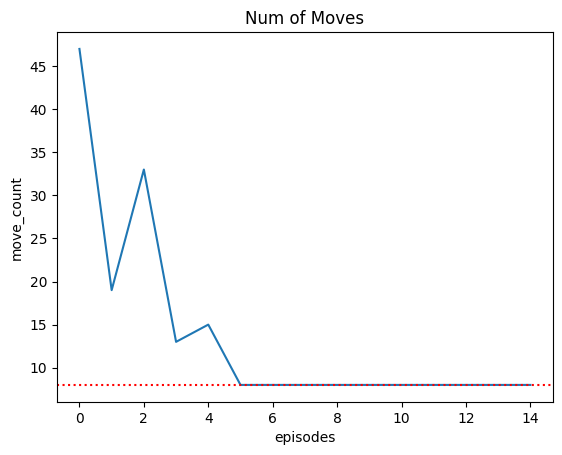

In [ ]:
plt.plot(total_moves)
plt.axhline(y=min(total_moves), color='r', linestyle=':')
plt.xlabel('episodes')
plt.ylabel('move_count')
plt.title('Num of Moves')
plt.show()

In [ ]:
# 정책 테이블 표현하기

policy_table_df = pd.DataFrame()

for x in range(env.width):
    for y in range(env.height):
        policy_table_df[f"({x},{y})"] = pi.policy_table[x][y]

policy_table_df = policy_table_df.T # transpose
col_names = dict(zip(range(len(env.action_space)), env.action_space)) # zip() : 각 action에 대한 번호를 튜플로 매핑
policy_table_df.rename(columns=col_names, inplace=True) # df.rename(columns = {'old_nm' : 'new_nm'}, inplace = True)

policy_table_df

,up,down,left,right
"(0,0)",0.0,0.5,0.0,0.5
"(0,1)",0.0,0.5,0.0,0.5
"(0,2)",0.0,0.5,0.0,0.5
"(0,3)",0.0,0.5,0.0,0.5
"(0,4)",0.0,1.0,0.0,0.0
"(1,0)",0.0,0.5,0.0,0.5
"(1,1)",0.0,0.5,0.0,0.5
"(1,2)",0.0,0.5,0.0,0.5
"(1,3)",0.0,0.5,0.0,0.5
"(1,4)",0.0,1.0,0.0,0.0


## 02 Value Iteration

In [ ]:
class ValueIteration:
    def __init__(self, env):
        self.env = env
        self.action_space = env.action_space
        self.num_actions = env.num_actions

        self.value_table = np.zeros(shape=(env.height, env.width)).tolist()

        self.gamma = 0.9

    def value_iteration(self):
        for state in self.env.total_states:

            if state == self.env.end_point:
                self.value_table[state[0]][state[1]] = 0.0

            else:
                value_list = []
                # 벨만 최적 방정식
                for action_idx in range(self.num_actions):
                    next_state = self.env.state_after_action(state, action_idx)
                    reward = self.env.get_reward(state, action_idx)
                    next_value = self.get_value(next_state)
                    value = reward + self.gamma * next_value
                    value_list.append(value)

                # 최댓값을 다음 가치함수로 대입
                self.value_table[state[0]][state[1]] = max(value_list)

    def get_action(self, state):
        if state == self.env.end_point:
            return []

        else:
            value_list = []
            for action_idx in range(self.num_actions):
                next_state = self.env.state_after_action(state, action_idx)
                reward = self.env.get_reward(state, action_idx)
                next_value = self.get_value(next_state)
                value = reward + self.gamma * next_value
                value_list.append(value)

            max_value = np.max(value_list)
            max_indices = np.where(value_list == max_value)[0]
            action_idx = np.random.choice(max_indices)

            return action_idx


    def get_value(self, state):
        return self.value_table[state[0]][state[1]]

## main_VI

In [ ]:
env = GridWorldEnvironment(start_point=(0,0), end_point=(4,4), gridworld_size=(5,5))

vi = ValueIteration(env)

EPISODES = 15
RENDER_END = True
total_moves = []

In [ ]:
for epi in range(EPISODES):
    move_cnt = 0
    env.traces = []
    state = env.start_point

    vi.value_iteration()

    while state != env.end_point:
        action_idx = vi.get_action(state)
        next_state = env.state_after_action(state, action_idx)
        state = next_state

        env.traces.append(state)
        move_cnt += 1

    total_moves.append(move_cnt)

    print(f"episode : {epi+1} / {EPISODES} __ move_cnt : {move_cnt}")

    if RENDER_END:
        env.render()

episode : 1 / 15 __ move_cnt : 20
S . . . . 
X X . . . 
X X . . . 
X . . . . 
X X X X A 

episode : 2 / 15 __ move_cnt : 29
S X X X . 
X X X X . 
. X X . . 
. . X X X 
. . . . A 

episode : 3 / 15 __ move_cnt : 12
S X X X X 
. . . . X 
. . . . X 
. . . . X 
. . . . A 

episode : 4 / 15 __ move_cnt : 19
S X . . . 
X X . . . 
. X . . . 
. X X X X 
. . . . A 

episode : 5 / 15 __ move_cnt : 10
S X X X X 
X . . . X 
. . . . X 
. . . . X 
. . . . A 

episode : 6 / 15 __ move_cnt : 9
S . . . . 
X . . . . 
X X X X X 
. . . . X 
. . . . A 

episode : 7 / 15 __ move_cnt : 8
S X X X X 
. . . . X 
. . . . X 
. . . . X 
. . . . A 

episode : 8 / 15 __ move_cnt : 8
S X . . . 
. X . . . 
. X . . . 
. X . . . 
. X X X A 

episode : 9 / 15 __ move_cnt : 8
S X X X . 
. . . X . 
. . . X . 
. . . X . 
. . . X A 

episode : 10 / 15 __ move_cnt : 8
S X X X X 
. . . . X 
. . . . X 
. . . . X 
. . . . A 

episode : 11 / 15 __ move_cnt : 8
S X . . . 
. X . . . 
. X . . . 
. X X . . 
. . X X A 

episode : 12 /

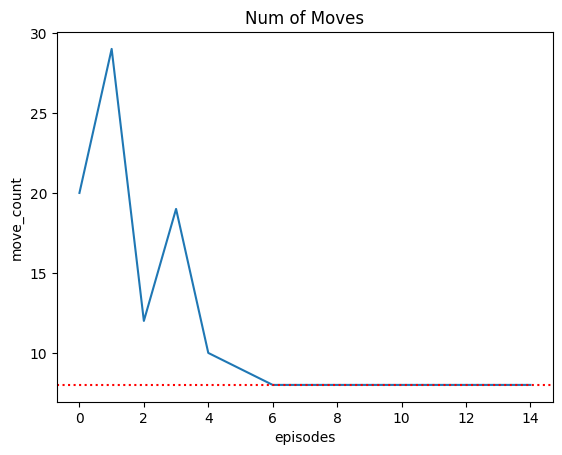

In [ ]:
plt.plot(total_moves)
plt.axhline(y=min(total_moves), color='r', linestyle=':')
plt.ylabel("move_count")
plt.xlabel("episodes")
plt.title("Num of Moves")
plt.show()

In [ ]:
# 가치 테이블
np.array(vi.value_table).round(3) # np.round(수, 자리수) : 반올림

array([[0.478, 0.531, 0.59 , 0.656, 0.729],
       [0.531, 0.59 , 0.656, 0.729, 0.81 ],
       [0.59 , 0.656, 0.729, 0.81 , 0.9  ],
       [0.656, 0.729, 0.81 , 0.9  , 1.   ],
       [0.729, 0.81 , 0.9  , 1.   , 0.   ]])